In [1]:
using DrWatson
@quickactivate "sst-mot-analysis"

import DrWatson: datadir, srcdir
import DrWatson: @quickactivate
include(srcdir("compare_random_samples.jl"))

using GH19, TMI, PythonCall, Revise
using CSV, DataFrames

In [2]:
function iswetloc(loc, γ1::Grid, γ2::Grid)
    if length(loc) < 3
        loc3 = (loc..., γ1.depth[2])
        return (iswet(loc3,γ1) * iswet(loc3,γ2)) 
    elseif length(lo) == 3
        return (iswet(loc,γ1) * iswet(loc,γ2)) 
    end
end

iswetloc(x) = iswetloc(x, γ_lgm, γ_PI)

iswetloc (generic function with 2 methods)

In [3]:
# Configure LGM dataset
TMIversion_lgm = "LGM_90x45x33_G14"
A_lgm, Alu_lgm, γ_lgm, TMIfile_lgm, L_lgm, B_lgm = config(TMIversion_lgm);

# Configure PI dataset
TMIversion_PI = "modern_180x90x33_GH11_GH12"
A_PI, Alu_PI, γ_PI, TMIfile_PI, L_PI, B_PI = config(TMIversion_PI);

A
  0.264778 seconds (642.76 k allocations: 68.052 MiB, 2.67% gc time, 83.48% compilation time)
Alu
  0.683675 seconds (507.45 k allocations: 502.498 MiB, 1.28% gc time, 10.39% compilation time)
L=
  0.089286 seconds (83.79 k allocations: 4.447 MiB, 95.36% compilation time)
B=
  0.020430 seconds (16.52 k allocations: 872.719 KiB, 89.98% compilation time)
A
  0.077815 seconds (7.56 k allocations: 127.113 MiB, 8.48% gc time, 38.45% compilation time)
Alu
  4.218498 seconds (414 allocations: 2.810 GiB, 2.67% gc time, 0.21% compilation time)
L=
  0.233034 seconds (8.39 M allocations: 237.491 MiB, 9.76% gc time, 39.47% compilation time)
B=
  0.015599 seconds (6.19 k allocations: 7.271 MiB, 20.05% compilation time)


In [4]:
γ_lgm.depth[1:3]

3-element Vector{Float64}:
  0.0
 10.0
 20.0

In [5]:
OC3_locs_df = DataFrame(CSV.File(datadir("Clark2024.csv")))[:, 2:end]

Row,Lat (¡N),Lon (¡E),Depth (m),Proxy,Ocean basin,Start (Ma),End (Ma),Resolution (kyr)
,Float64,Float64,String15,String15,String15,Float64,Float64,Int64
1,69.2,-12.7,1812,Alkenone,N. At.,5.98,2.864,6
2,61.4,-24.1,1660,Mg/Ca,N. At.,3.05,2.5,2
3,60.4,-23.6,1984,Alkenone,N. At.,1.5,0.494,5
4,58.0,-16.0,1134,Alkenone,N. At.,5.959,0.0,5
5,56.04,-23.2,2301,Mg/Ca,N. At.,5.983,3.018,12
6,53.5,-20.3,2199,Faunal,N. At.,0.192,0.002,1
7,51.0,168.0,2391,Alkenone,N. Pac.,5.993,2.706,34
8,50.0,168.0,3244,Alkenone,N. Pac.,5.913,0.004,8
9,49.9,-24.2,3883,Mg/Ca,N. At.,3.411,2.568,3


In [6]:
OC3_locs_df = DataFrame(CSV.File(datadir("clark2024.csv")))[:, 2:end]
OC3_resolution = OC3_locs_df[!, 8]
OC3_locs_df = OC3_locs_df[OC3_resolution .<= 4, :]
OC3_lons = OC3_locs_df[!, 2]
OC3_lons[OC3_lons .< 0.0] .+= 360

OC3_lats = OC3_locs_df[!, 1]

nOC3_locs = size(OC3_locs_df, 1)

OC3_locs = Vector{Tuple{Float64, Float64}}(undef, nOC3_locs)

[OC3_locs[i] = (OC3_lons[i], OC3_lats[i]) for i in eachindex(OC3_locs)]
            
OC3_locs = unique(OC3_locs[iswetloc.(OC3_locs)]);

In [7]:
Nboot = 2500
N_sample = length(OC3_locs)
OC3_locs_sampl_results  = bootstrap_PI_lgm_differences(N_sample, Nboot; locs = OC3_locs);

A
  0.014947 seconds (4.34 k allocations: 34.887 MiB)
Alu
  0.581412 seconds (88 allocations: 477.426 MiB, 3.41% gc time)
L=
  0.002456 seconds (764 allocations: 63.273 KiB)
B=
  0.001703 seconds (763 allocations: 63.250 KiB)
A
  0.036414 seconds (5.23 k allocations: 118.943 MiB, 14.55% gc time)
Alu
  4.199216 seconds (87 allocations: 2.814 GiB, 0.51% gc time)
L=
  0.128690 seconds (8.14 M allocations: 224.520 MiB, 4.15% gc time)
B=
  0.012113 seconds (6.14 k allocations: 7.270 MiB)
A
  0.035719 seconds (5.23 k allocations: 118.943 MiB, 19.78% gc time)
Alu
  4.100021 seconds (88 allocations: 2.810 GiB, 0.08% gc time)
L=
  0.126864 seconds (8.14 M allocations: 224.520 MiB, 5.63% gc time)
B=
  0.010722 seconds (6.14 k allocations: 7.270 MiB)


Running 2500 MC trials (n=81).. 100%|████████████████████| Time: 0:01:39


In [8]:
#https://www.science.org/doi/10.1126/science.adi1908

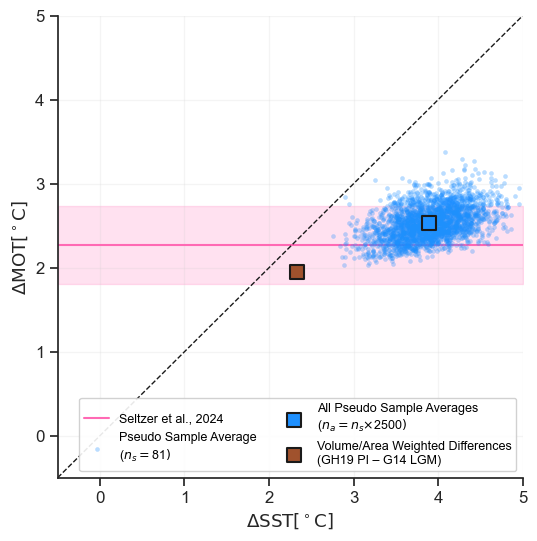

In [9]:
generate_temperature_difference_plot(
    OC3_locs_sampl_results,
    :uniform, N_sample, Nboot, plotsdir("S.LGM_PI_Temp_diff_weighted_OC3_samples.png"); xlims = (-0.5, 5)
);